In [1]:
import utils
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
image_pre_path = './simulations/fits_files/i/'

In [2]:
class lens_light_test:
    def __init__(self, image_array):
        self.image_array=np.array(image_array)
    def test(self):
        image_bellow_zero=-self.image_array
        min_value=np.min(image_bellow_zero)
        value_50 = image_bellow_zero[50][50]
        #print(value_50/min_value)
        if value_50/min_value<0.3:
            [x_index], [y_index] = np.where(image_bellow_zero==min_value)
            return False, value_50/min_value, x_index, y_index
        else:
            [x_index], [y_index] = np.where(image_bellow_zero==min_value)
            return True, value_50/min_value, x_index, y_index

In [3]:
class find_radius:
    def __init__(self, pre_set_sigma, image_array):
        axis_integrated_image = np.sum(image_array, axis=0)
        over_mean_int_image=axis_integrated_image[50-pre_set_sigma:50+pre_set_sigma+1]
        self.y=over_mean_int_image/np.max(over_mean_int_image)
        self.x=np.linspace(50-pre_set_sigma, 50+pre_set_sigma, 2*pre_set_sigma+1, dtype=int)
    
    def gauss_func(self, x_val, norm_val, x0_val, sigma_val):
        return norm_val*np.exp(-0.5*((x_val-x0_val)/sigma_val)**2)

    def chi_squared(self, par):
        norm, x0, sigma = par
        gauss_array = self.gauss_func(self.x, norm, x0, sigma)
        return np.sum((self.y-gauss_array)**2)
    
    def get_radius(self, init_guess=[1., 50, 2], method='Nelder-Mead'):
        result=minimize(self.chi_squared, init_guess, method=method)
        return result.x

In [4]:
obj_idx=np.array(pd.read_csv('test_dataset.csv')['OBJID-g'][:25]).reshape(5,5)
obj_idx

array([[1502, 2587, 2654, 1056,  706],
       [ 107,  590, 2469, 2414, 1601],
       [2465,  229,  916,  795, 3022],
       [3544, 1074, 3352, 1745, 1085],
       [ 927, 3050, 1118,  643, 4768]])

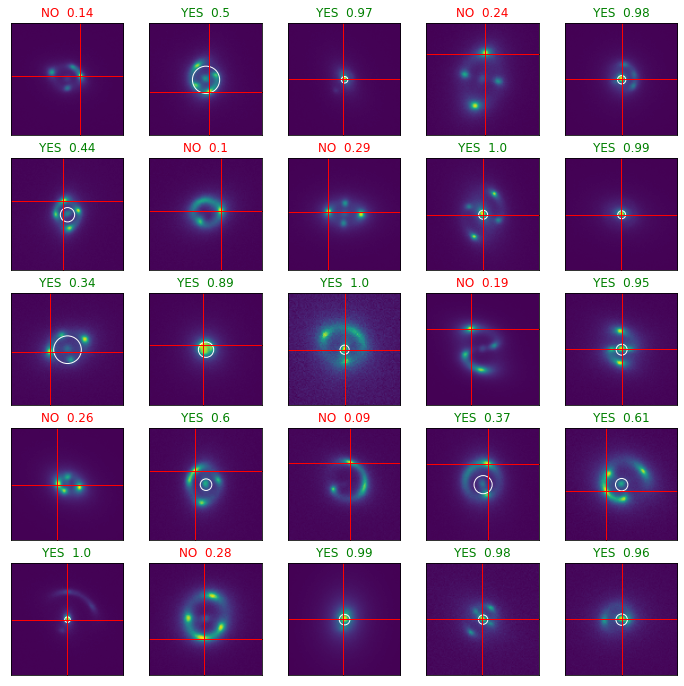

In [5]:
fig, ax = plt.subplots(len(obj_idx), len(obj_idx[0]), figsize=(12, 12))
for i in range(0, len(obj_idx)):
    for j in range(0, len(obj_idx[i])):
        cutout = fits.open(image_pre_path+str(int(obj_idx[i][j])-1)+'.fits')[0].data
        teste=lens_light_test(cutout)
        has_len_light, f, x, y=teste.test()
        #print(has_len_light)
        if has_len_light:
            finder = utils.find_radius(pre_set_sigma=2, image_array=cutout)
            _, _, mask_radius= finder.get_radius()
            circle = plt.Circle((50., 50.), float(mask_radius), color='w', fill=False, lw=1)
            ax[i][j].add_patch(circle)
            ax[i][j].imshow(cutout)
            ax[i][j].plot(y, x, 'r+', markersize=500)
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_title('YES  '+str(round(f, 2)), color='g')
        else:
            ax[i][j].imshow(cutout)
            ax[i][j].plot(y, x, 'r+', markersize=500)
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_title('NO  '+str(round(f, 2)), color='r')